The algorithm is designed according to the original arcticle

Reinforcement Learning for Continious-Time Optimal Execution:
Actor-Critic Algorithm and Error Analysis (Boyu Wang, Xuefeng Gao, Lingfei Li)

All analytical functions used below are referenced by the same numbers 
as in the article

In [1]:
from typing import TypeVar, Generic, NewType
from abc import ABC, abstractmethod
from dataclasses import dataclass

S = TypeVar('S')

# abstract state class
class State(ABC, Generic[S]):
    def __init__(self, state: S) -> None:
        self.state = state
    
    @property
    @abstractmethod
    def isTerminal(self):
        pass
        
NonTerminal = State # for annotation convenience
Terminal    = State
        
# abstract environment class
class Environment(ABC, Generic[S]):
    def __init__(self, initial_state: State[S]) -> None:
        self.state : State[S] = initial_state
    
    @abstractmethod
    def reset(self) -> None:
        pass
       
    @abstractmethod
    def step(self, execution_mode) -> State[S]:
        pass

In [2]:
class UnderlyingStochasticProcess(ABC):
    '''
        Abstract class for stochastic process
    '''
    def __init__(self, start_price: float):
        self.price = start_price
        
    @abstractmethod
    def next_state(self):
        pass
    
# for annotation convenience
Price, Revenue = NewType('Price', float), NewType('Revenue', float)
    
class AlmgrenChrissABM(UnderlyingStochasticProcess):
    '''
        Specify underlying evolution process
        on Almgren-Chriss model with params:
        sigma, kappa, eta
    '''
    def __init__(self, 
                 start_price: float,
                 env_sigma: float,
                 env_kappa: float,
                 env_eta: float,
                 seed: int = 0,
                 ) -> None:
        self.start_price  = start_price
        self.price        = start_price
        self.env_sigma    = env_sigma   # volatility of the ABM process
        self.env_kappa    = env_kappa   # permanent market impact parameter
        self.env_eta      = env_eta     # temporary price impact parameter
        self.seed         = seed
        np.random.seed(seed)
        
    def reset(self) -> None:
        self.price = self.start_price
      
    def next_state(self, dt: float, sqrt_dt: float, trading_rate: float, 
            frozen_price: bool = False) -> Revenue:
        revenue = -trading_rate * (self.price + self.env_eta * trading_rate) * dt
        if frozen_price:
            return revenue
        else:
            self.price += self.env_kappa * trading_rate * dt\
                + self.start_price * np.random.normal(loc=0, scale=sqrt_dt * self.env_sigma) 
            return revenue

In [3]:
from typing import NewType
import numpy as np
  
from dataclasses import dataclass
#------------------------------------------------------------#
#    Dataclass containter for the state of env
#------------------------------------------------------------#
@dataclass
class InventoryExecutionState:
    '''
        Container for portfolio execution state:
        current inventory -> 0
        accounting current inventory and remaining time.
    '''
    initial_inventory : int   = 1 
    current_inventory : float = 1
    remaining_time :    float = 1
    
    @property
    def isTerminal(self) -> bool:
        '''
            The terminal condition below allows us to use the class 
            for portfolio liquidation as well as for portfolio acquisition
        '''
        return abs(self.initial_inventory - self.current_inventory) > abs(self.initial_inventory) - 1e-10 \
                or self.remaining_time <= 0
#------------------------------------------------------------# 

from copy import deepcopy
from typing import Tuple
#------------------------------------------------------------#
#    Environment interface class for state and process
#------------------------------------------------------------#
class ExecutionEnvironment(Environment[InventoryExecutionState]):
    '''
        Specification for Environment parameterized with
        execution state class. It uses state container
        and stochastic process so both can be chosen
        arbitrary for different state and processes types.
    '''
    
    def __init__(self, 
                 initial_state: InventoryExecutionState,
                 process: AlmgrenChrissABM
        ) -> None:
        self.__initial_state = deepcopy(initial_state)
        self.state           = deepcopy(initial_state)
        self.process         = deepcopy(process)
    
    def reset(self) -> Price:
        self.state = deepcopy(self.__initial_state)
        self.process.reset()
        return self.process.price
    
    def step(self, order: float, # in the current version is float 
             exec_time: float, 
             dt: float, 
             frozen_price: bool = False
            ) -> Tuple[Price, Revenue]:
        '''
            On each step the agent executes inventory with 'order' size.
            Step takes 'exec_time' for the execution.
            If order is being executed evenly every dt 
            then we have (exec_time/dt) equivalent orders to execute.
            'frozen_time' is responsible for price impact while order is executed.
        '''
        
        if self.state.isTerminal:
            #print('State is terminal')
            return 0, 0
        
        # if we execute a larger order than the remaining inventory
        # or required time is greater than the remaining one -> decrease it
        inv_diff = self.state.current_inventory + order # order < 0 since we sell
        if np.sign(inv_diff * self.state.current_inventory) < 0:
            order -= inv_diff
            # print(f'Order was decreased by {inv_diff:.3E}, order = {order:.3E}, remaining time = {self.state.remaining_time:.3E}')
        time_diff = self.state.remaining_time - exec_time
        if time_diff < 0:
            exec_time += time_diff
            if exec_time < dt : dt = exec_time # to be sure that the last order is going to be executed !
            ord_diff = self.state.current_inventory + order
            order = -self.state.current_inventory # to liquidate all remaining inventory
            # print(f'Order is going to be executed by {-time_diff:.3E} faster, execution time = {exec_time:3E}, order was increased by = {ord_diff:.3E}, order = {order:.3E}')
        
        sqrt_dt = np.sqrt(dt)
        trading_rate = order / exec_time
        orders = int ( exec_time / dt + 1e-8 ) # number of orders is integer
        revenue = 0
        for i in range(orders):
            revenue += self.process.next_state(dt, sqrt_dt, trading_rate, frozen_price)
            
        if frozen_price: # exploratory mode: get revenue for diff orders without price change
            return self.process.price, revenue
        else: # otherwise update price state
            self.state.current_inventory += order
            self.state.remaining_time    -= exec_time
            return self.process.price, revenue
#------------------------------------------------------------# 

In [4]:
from typing import List
from copy import deepcopy

#------------------------------------------------------------#
#    Almgren-Chriss model Agent
#------------------------------------------------------------#
class ACAgent:
    '''
        the agent decides what size of market order to execute
        according to Almgren-Chriss model optimal execution
        parameters:
        'risk_aversion_lambda' is a measure how the agent prefers to act:
            sell instantaneously (lambda ~0) or sell uniformly in time horizon (lambda >> 0)
        'dzeta' is a measure of willingness to explore (consider as standard deviation in random choosing (acc. Gauss))
        'phi'  : policy parametrization vector
        'psy'  : kappa, eta, sigma approximation vector
        'theta': value-function parametrization vector
    '''
    def __init__(self,
                 risk_aversion_lambda: float, 
                 dzeta: float,
                 phi: np.ndarray, 
                 theta: np.ndarray
                ) -> None:
        self.ra_lambda = risk_aversion_lambda
        self.dzeta     = dzeta
        self.phi       = deepcopy(phi)
        self.psy       = np.zeros
        self.M_phi     = np.eye(3)
        self.M_phi_inv = np.eye(3)
        self.theta     = deepcopy(theta)
        self.theta_t   = deepcopy(theta)
        
    '''feedback control according to formula (23)'''
    def get_mu(self, inventory: float, T: float, t: float) -> float: 
        return -inventory * self.phi[0] / np.tanh( self.phi[0] * (T - t + 1e-20) )

    def get_sigma(self):
        return np.sqrt(self.dzeta * self.phi[1])
        
    def get_action(self, inventory: float, T: float, t: float) -> float:
        action = np.random.normal(
                    loc= self.get_mu(inventory, T, t),
                    scale=self.get_sigma())
        return action
    
    def get_det_action(self, inventory: float, T: float, t: float) -> float:
        action = np.random.normal(
                    loc= self.get_mu(inventory, T, t),
                    scale=0)
        return action
    
    # update matrixes independently since we have to control the update order!
    '''M(Ф) is given by (28)'''
    def update_M_phi(self, price_S0: float) -> None:
        self.M_phi[1,1], self.M_phi[2,1] = self.phi[0], self.phi[0]
        self.M_phi[1,2], self.M_phi[2,2] = self.ra_lambda * price_S0 ** 2 / self.phi[0], -self.ra_lambda * price_S0 ** 2 / self.phi[0]
    
    '''M(Ф)^-1 is given by (29)'''
    def update_M_phi_inv(self, price_S0: float) -> None:
        self.M_phi_inv[1,1], self.M_phi_inv[1,2] = 1 / 2 / self.phi[0], 1 / 2 / self.phi[0]
        self.M_phi_inv[2,1], self.M_phi_inv[2,2] = self.phi[0] / 2 / self.ra_lambda / price_S0 ** 2, -self.phi[0] / 2 / self.ra_lambda / price_S0 ** 2
        
    '''psy vector of implied environment parameters is from the line of (29)'''
    def update_psy(self) -> None:
        self.psy = np.dot(self.M_phi_inv, self.theta_t)
        
    '''g(phi_1) is given by (35)'''
    def g_function(self, trade_horizon: float) -> None:
        f_term = 1 / np.tanh(self.phi[0] * trade_horizon) / self.phi[0]
        s_term = trade_horizon / np.sinh(self.phi[0] * trade_horizon) ** 2
        t_term = -2 * self.phi[0] * trade_horizon ** 2 / np.sinh(self.phi[0] * trade_horizon) ** 2\
                    / np.tanh(self.phi[0] * trade_horizon) 
        return f_term + s_term + t_term
    
    '''the value function is given by (26)'''
    def value_function(self, T: float, t: float, 
                       inventory: float, price_S: float) -> None:
        f_term = inventory * price_S
        s_term = self.dzeta / 2 * ( np.log(2 * np.pi * np.exp(1) * self.dzeta * self.phi[1])\
                    - (self.theta[1] + self.theta[2]) * self.phi[1] / self.phi[0] ) * (T - t)
        t_term = -inventory ** 2 / 2 * ( self.theta[0] + self.theta[1] / np.tanh(self.phi[0] * (T - t + 1e-20))\
                    + self.theta[2] * self.phi[0] * (T - t) / (np.sinh(self.phi[0] * (T - t + 1e-20))) ** 2 )
        return f_term + s_term + t_term
    
    '''A_matrix is given in (41)'''
    def A_matrix(self, T:float, inventory_q0: float):
        A = np.zeros((3,3))
        A[0, 1] = self.dzeta * self.phi[1] / 2 / self.phi[0]
        A[1, 0] = inventory_q0 ** 2 / 2 / np.sinh(self.phi[0] * T)**2
        A[0, 2] = A[0, 1] + A[1, 0] * self.phi[0]
        A[2, 1] = inventory_q0**2 / 4 / np.sinh(self.phi[0] * T)**2
        return A
    
    '''I_matrix is given in (42)'''
    def I_matrix(self, T: float):
        I_1 = T**3 / 3
        I_2 = np.sinh(4 * self.phi[0] * T) / 32 / self.phi[0] - np.sinh(2 * self.phi[0] * T) / 4 / self.phi[0] + 3 / 8 * T
        I_3 = np.sinh(4 * self.phi[0] * T) / 8 / self.phi[0] - T / 2
        I_4 = T * np.sinh(2*self.phi[0]*T) / 4 / self.phi[0] + (1 - np.cosh(2*self.phi[0]*T)) / 8 / self.phi[0]**2 - T**2 / 4
        I_5 = T * np.cosh(2*self.phi[0]*T) / 2 / self.phi[0] - np.sinh(2*self.phi[0]*T) / 4 / self.phi[0]**2
        I_6 = np.sinh(self.phi[0] * T)**4 / 2 / self.phi[0]
        I = np.zeros((3,3))
        I[0,0], I[0,1], I[0,2] = I_1, I_4, I_5
        I[1,0], I[1,1], I[1,2] = I_4, I_2, I_6
        I[2,0], I[2,1], I[2,2] = I_5, I_6, I_3
        return I
    
    '''S_matrix is given after (42), above the Lemma 5.2'''
    def S_matrix(self, T: float, inventory_q0: float):
        A_m, I_m = self.A_matrix(T, inventory_q0), self.I_matrix(T)
        return (A_m.T @ I_m) @ A_m
    
    '''by definition in 5, p.16'''
    def L_norm(self, s_matrix: np.ndarray):
        return np.max( np.sum(np.abs(s_matrix), axis=1) )

In [5]:
#------------------------------------------------------------#
# additional debugging functions
#------------------------------------------------------------#

def return_optimal_params(
    env_sigma: float, env_kappa: float, env_eta: float, 
    price_S0: float, risk_aversion: float
) -> List[np.ndarray]:
    '''calculate optimal parameters from analytical functions
       using environment parameters'''
    
    '''phi is given by(43)'''
    true_phi_1   = np.sqrt(risk_aversion * env_sigma**2 * price_S0**2 / env_eta)
    true_phi_2   = 1 / 2 / env_eta
    '''theta is given by (27)'''
    true_theta_1 = env_kappa
    true_theta_2 = true_phi_1 * env_eta + risk_aversion * price_S0**2 * env_sigma**2 / true_phi_1
    true_theta_3 = true_phi_1 * env_eta - risk_aversion * price_S0**2 * env_sigma**2 / true_phi_1
    return np.array([true_phi_1, true_phi_2]), np.array([true_theta_1, true_theta_2, true_theta_3])

def g(phi, T):
    '''is given by (35)'''
    ft = 1 / (np.tanh(phi * T)) / phi
    st = T / np.sinh(phi)**2
    tt = -2 * phi * T**2 / np.sinh(phi * T)**2/np.tanh(phi*T)
    return ft+st+tt

def gamma(env_sigma: float, inventory_q0: float, price_S0: float, T: float, phi: np.ndarray):
    f_factor = env_sigma**2 * inventory_q0**2 * price_S0**2 / phi[0] / np.sinh(phi[0] * T)**2
    s_factor = (np.cosh(2*phi[0]*T) - 1) / 8 / phi[0] - phi[0] * T**2  / 4
    return f_factor * s_factor
    

In [6]:
import matplotlib.pyplot as plt
from scipy.special import roots_hermite

def agent_checking(
    agent: ACAgent, 
    exec_env: ExecutionEnvironment, 
    N_trades: int = 100,
    episodes: int = 100,
    return_loss: bool = True,
) -> None:
    #print(f'Agent phi = {agent.phi}')
    
    # for Gauss-Hermite quadrature
    explor_grid_nodes = 23
    reward_vector = np.zeros(explor_grid_nodes)
    abscissas_y, weights_w = roots_hermite(explor_grid_nodes, mu=False)
    
    exec_env.reset()
    exec_time = exec_env.state.remaining_time
    dt =  exec_time / N_trades
    
    MLoss = np.zeros(episodes)
    total_revenue = np.zeros(episodes)
    for ep in range(episodes):
        exec_env.reset()
        revenues = []
        price = [exec_env.process.price]
        inventory = [exec_env.state.initial_inventory]
        TWAP = [exec_env.step(-exec_env.state.current_inventory, exec_time, exec_time, frozen_price=True )[1]]
        agent.value_function(exec_time, 0, exec_env.state.current_inventory, exec_env.process.price)
        state_values = [agent.value_function(exec_time, 0, exec_env.state.current_inventory, exec_env.process.price)]
        exploratory_reward = np.zeros(N_trades + 1)
        delta_P = np.zeros(N_trades + 1)
        
        for time_step in range(N_trades):

            prev_price = exec_env.process.price

            mu    = agent.get_mu(exec_env.state.current_inventory, exec_time, exec_time - exec_env.state.remaining_time)
            sigma = agent.dzeta * agent.phi[1]
            #print('start')
            for j in range(explor_grid_nodes):
                trading_rate_v = mu + np.sqrt(2) * sigma * abscissas_y[j]
                #print(f'explore {trading_rate_v * dt}')
                _, reward_vector[j] = exec_env.step( trading_rate_v * dt, dt, dt, frozen_price=True ) # = order size inside      
            #print('finish')

            mu = agent.get_action(exec_env.state.current_inventory, exec_time, exec_time - exec_env.state.remaining_time)
            order = mu * dt
            next_price, revenue = exec_env.step(order, dt, dt/100)
            #print(f'order = {order}, v = {order/dt}, revenue = {revenue}, price = {next_price}')
            revenues.append(revenue)
            TWAP.append(exec_env.step(-exec_env.state.current_inventory, exec_env.state.remaining_time, exec_env.state.remaining_time, frozen_price=True )[1]) #exec_env.state.current_inventory * exec_env.process.price)
            price.append(exec_env.process.price)
            inventory.append(exec_env.state.current_inventory)
            state_values.append(agent.value_function(exec_time, exec_time - exec_env.state.remaining_time, exec_env.state.current_inventory, exec_env.process.price))

            exploratory_reward[time_step] = np.dot(weights_w, reward_vector) / np.sqrt(np.pi)
            # calculate sq_delta_P 
            delta_P[time_step] = ( exploratory_reward[time_step] + prev_price * order + inventory[-2] * (next_price - prev_price) )
            #print(exec_env.state.current_inventory)

        # print(f'state_values {np.asarray(state_values).shape}, tis {np.linspace(0, exec_time, N_trades+1).shape}, exp_rew {exploratory_reward.shape}, delta_P {delta_P.shape}')
        MLoss[ep] = np.square(-np.asarray(state_values) + agent.dzeta * (exec_time - np.linspace(0, exec_time, N_trades+1))\
               * np.log(np.sqrt(2*np.pi*np.exp(1)*agent.dzeta*agent.phi[1])) + np.cumsum( (exploratory_reward - agent.ra_lambda * delta_P**2)[::-1] )).sum() * dt
        total_revenue[ep] = np.asarray(revenues).sum()
        
    #print(f'Averaged Martingale Loss = {MLoss.mean()}, std = {MLoss.std()}')
    #print(inventory, price, exec_time, dt)
    plt.figure(figsize=(10,3))
    plt.title(f'Sanity check for state-value function, phi = {agent.phi}')
    plt.plot(TWAP, label = 'Revenue realized using TWAP with frozen price (with impact)')
    plt.plot(state_values, label = 'Expected revenue (state_value approximation)')
    plt.legend(); plt.grid()
    plt.show()
    
    if return_loss:
        return (MLoss.mean(), agent.phi)
    else:
        return (total_revenue.mean(), agent.phi)
    
def wrapper(phi, seed, N_trades, episodes, return_loss):
    #print(inventory_q0, execution_time, start_price, env_sigma, env_kappa, env_eta,risk_aversion, dzeta, phi, theta)
    sf = InventoryExecutionState(inventory_q0, inventory_q0, execution_time)
    pr = AlmgrenChrissABM(start_price, env_sigma, env_kappa, env_eta, seed=seed)
    exec_env = ExecutionEnvironment(sf, pr)
    agent = ACAgent(risk_aversion, dzeta, phi, theta)
    exec_env = ExecutionEnvironment(sf, pr)
    return agent_checking(agent, exec_env, N_trades=N_trades, episodes=episodes, return_loss=return_loss)

Optimal params: phi = [  3000. 200000.], theta = [2.50000000e-07 1.50000000e-02 8.67361738e-19]


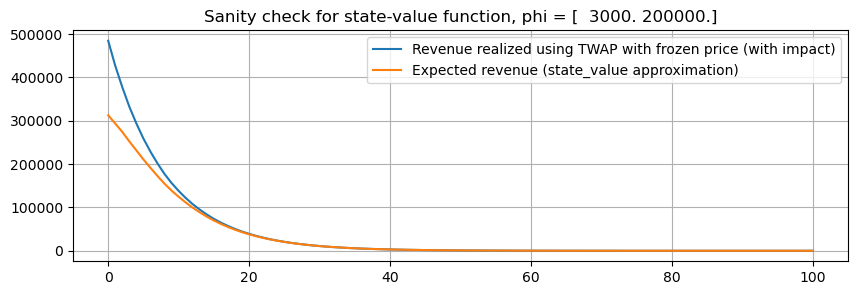

In [8]:
# inventory params
start_price = 100
inventory_q0 = 5e3
daily_volume = 5_000
bid_ask_spread = 1/8

# time params
execution_horizon = 1 # days
execution_time    = execution_horizon / 252   # there are 250 days per trading year
N_trades          = execution_horizon * 24 * 60 # 10min periods per day
dt                = execution_time / N_trades

sf = InventoryExecutionState(inventory_q0, inventory_q0, execution_time)

# environment params
env_sigma = 0.3
env_kappa = 2.5e-7
env_eta = 2.5e-6
risk_aversion = 1e4* env_eta
dzeta = 5

true_phi, true_theta = return_optimal_params(env_sigma, env_kappa, env_eta, start_price, risk_aversion)
phi, theta = true_phi, true_theta

print(f'Optimal params: phi = {true_phi}, theta = {true_theta}')

# create environment

pr = AlmgrenChrissABM(start_price, env_sigma, env_kappa, env_eta, seed=None)
exec_env = ExecutionEnvironment(sf, pr)

# create agent
agent = ACAgent(risk_aversion, dzeta, phi, theta)
revenue = agent_checking(agent, exec_env, N_trades=100, episodes=1, return_loss=True)

In [9]:
import itertools
from multiprocessing import Pool
import random
from matplotlib import cm

In [10]:
phis1 = np.linspace(0.5*true_phi[0], 1.5*true_phi[0], 30)
phis2 = np.linspace(0.5*true_phi[1], 1.5*true_phi[1], 30)
phis_coords = np.meshgrid(phis1, phis2)

phis = []
for phi1, phi2 in zip(phis_coords[0].flatten(), phis_coords[1].flatten()):
    phis.append([phi1, phi2])

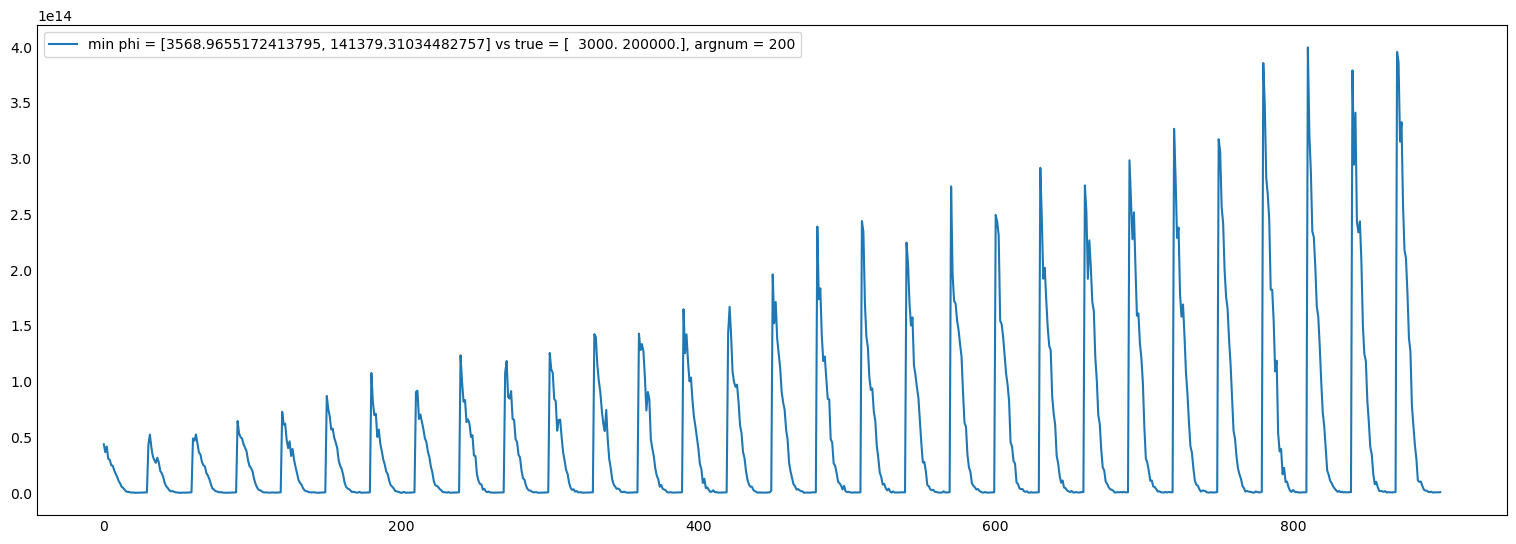

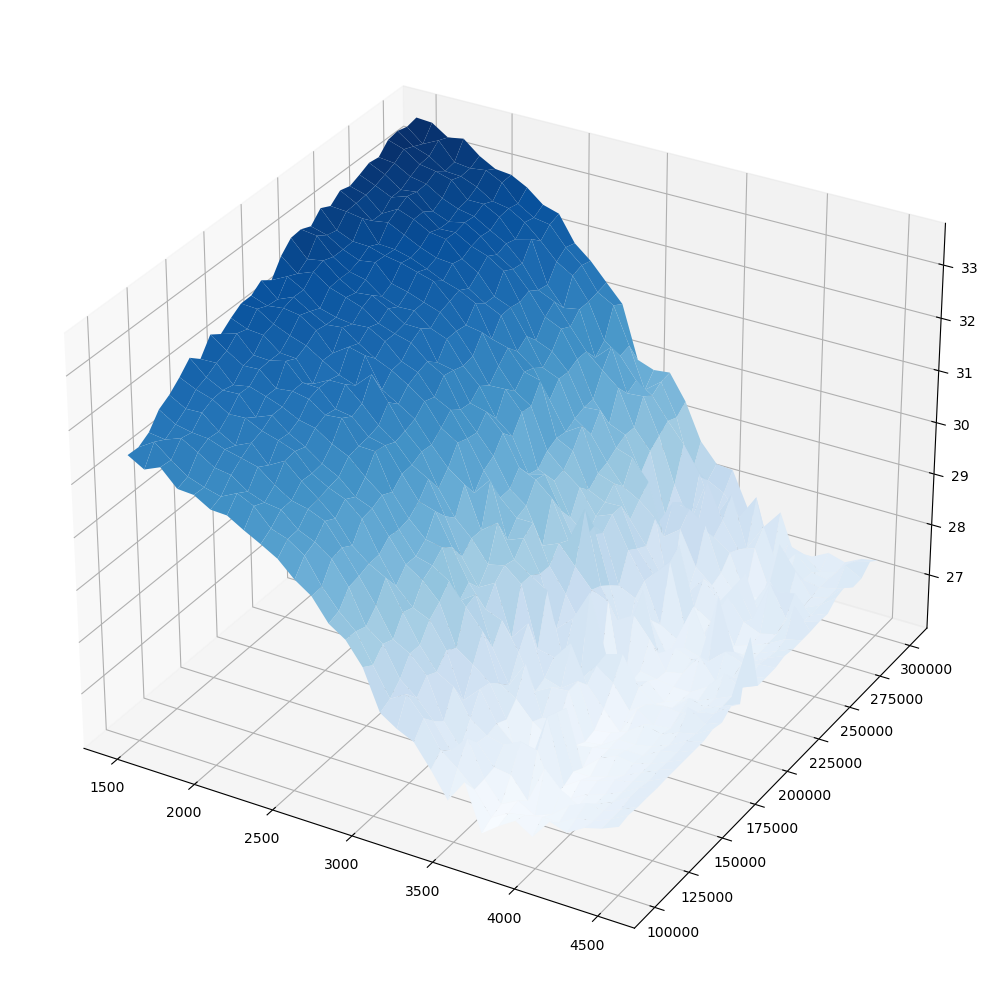

In [125]:
%%time
rand_seeds = np.random.randint(0, 100000, size=len(phis))
args = []
for phi_args, rs in zip(phis, rand_seeds):
    args.append((phi_args, rs, 100, 3000, True))

mloss = 0
with Pool(len(phis)) as pool:
    mloss = pool.starmap(wrapper, args)

losses = []
params = []
for loss, param in mloss:
    losses.append(loss)
    params.append(param)
    
min_arg = np.argmin(np.asarray(losses))
plt.figure(figsize=(15,5))
plt.plot(losses, label=f'min phi = {params[min_arg]} vs true = {true_phi}, argnum = {min_arg}')
plt.grid()
plt.legend()
plt.show()

losses_z = np.asarray(losses).reshape(phis_coords[0].shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
ax.plot_surface(phis_coords[0], phis_coords[1], np.log(losses_z), cmap=cm.Blues)
plt.show()

In [ ]:
%%time
rand_seeds = np.random.randint(0, 100000, size=len(phis))
args = []
for phi_args, rs in zip(phis, rand_seeds):
    args.append((phi_args, rs, 100, 15000, True))

mloss = 0
processes = 72
with Pool(processes) as pool:
    mloss = pool.starmap(wrapper, args)

losses = []
params = []
for loss, param in mloss:
    losses.append(loss)
    params.append(param)
    
min_arg = np.argmin(np.asarray(losses))
plt.figure(figsize=(15,5))
plt.plot(losses, label=f'min phi = {params[min_arg]} vs true = {true_phi}, argnum = {min_arg}')
plt.grid()
plt.legend()
plt.show()

losses_z = np.asarray(losses).reshape(phis_coords[0].shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
ax.plot_surface(phis_coords[0], phis_coords[1], np.log(losses_z), cmap=cm.Blues)
plt.show()

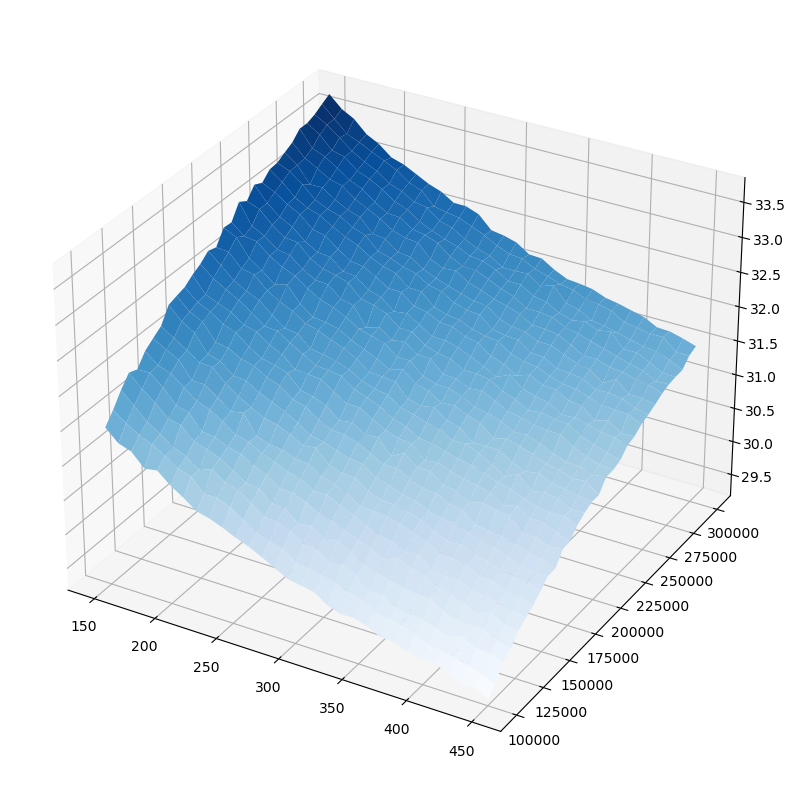

In [20]:
losses_z = np.asarray(losses).reshape(phis_coords[0].shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
ax.plot_surface(phis_coords[0], phis_coords[1], np.log(losses_z), cmap=cm.Blues)
plt.show()

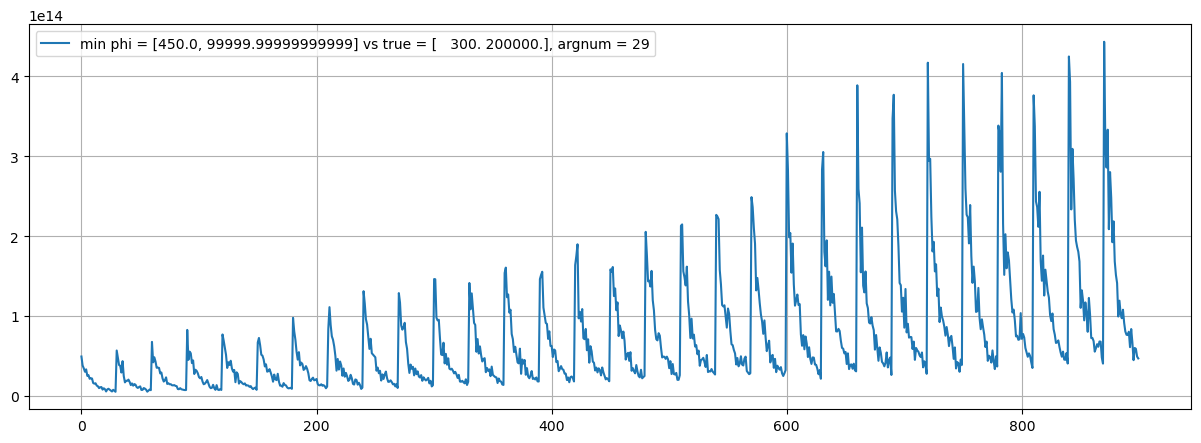

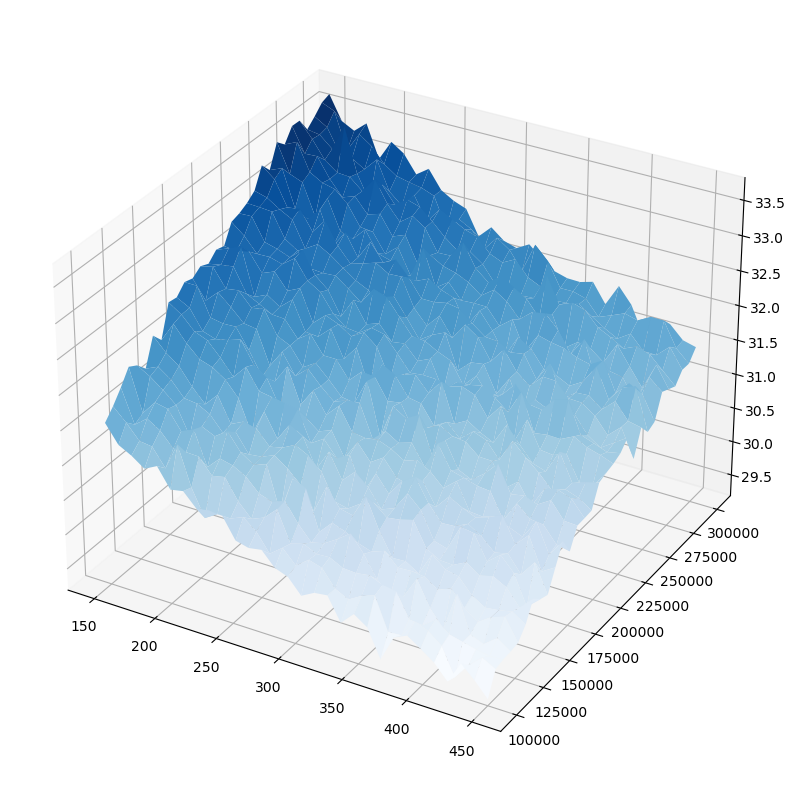

CPU times: user 1.87 s, sys: 4.21 s, total: 6.08 s
Wall time: 8min 2s


In [18]:
%%time
rand_seeds = np.random.randint(0, 100000, size=len(phis))
args = []
for phi_args, rs in zip(phis, rand_seeds):
    args.append((phi_args, rs, 100, 1000, True))

mloss = 0
processes = 72
with Pool(processes) as pool:
    mloss = pool.starmap(wrapper, args)

losses = []
params = []
for loss, param in mloss:
    losses.append(loss)
    params.append(param)
    
min_arg = np.argmin(np.asarray(losses))
plt.figure(figsize=(15,5))
plt.plot(losses, label=f'min phi = {params[min_arg]} vs true = {true_phi}, argnum = {min_arg}')
plt.grid()
plt.legend()
plt.show()

losses_z = np.asarray(losses).reshape(phis_coords[0].shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
ax.plot_surface(phis_coords[0], phis_coords[1], np.log(losses_z), cmap=cm.Blues)
plt.show()

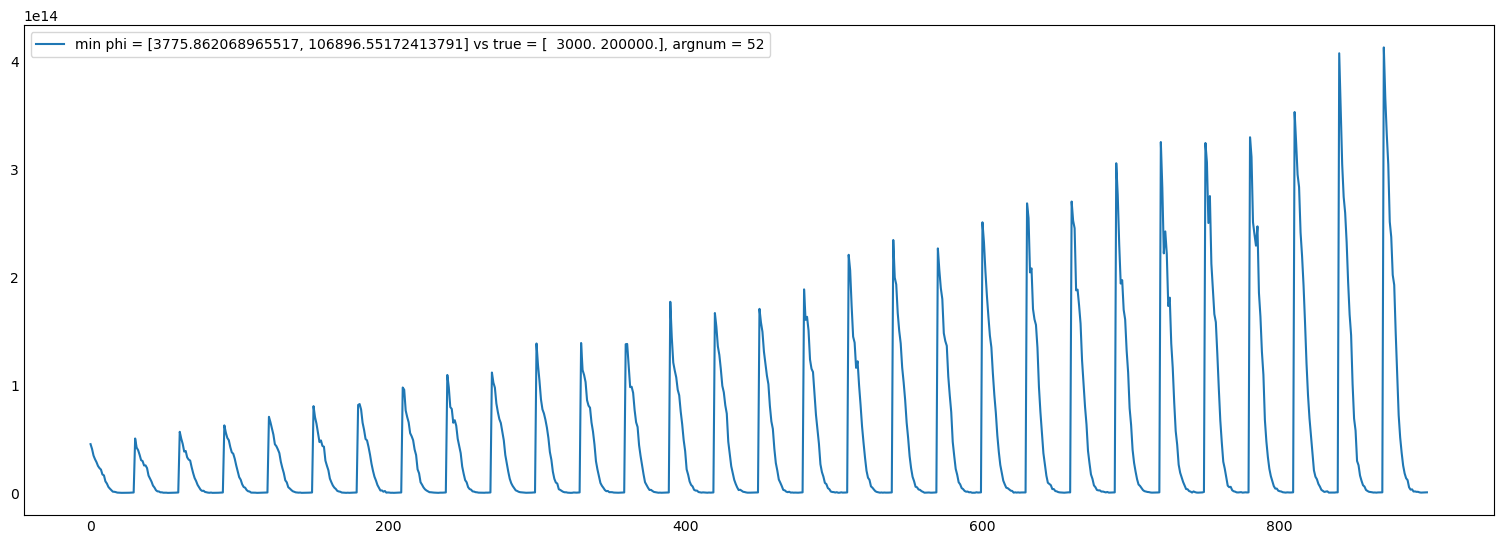

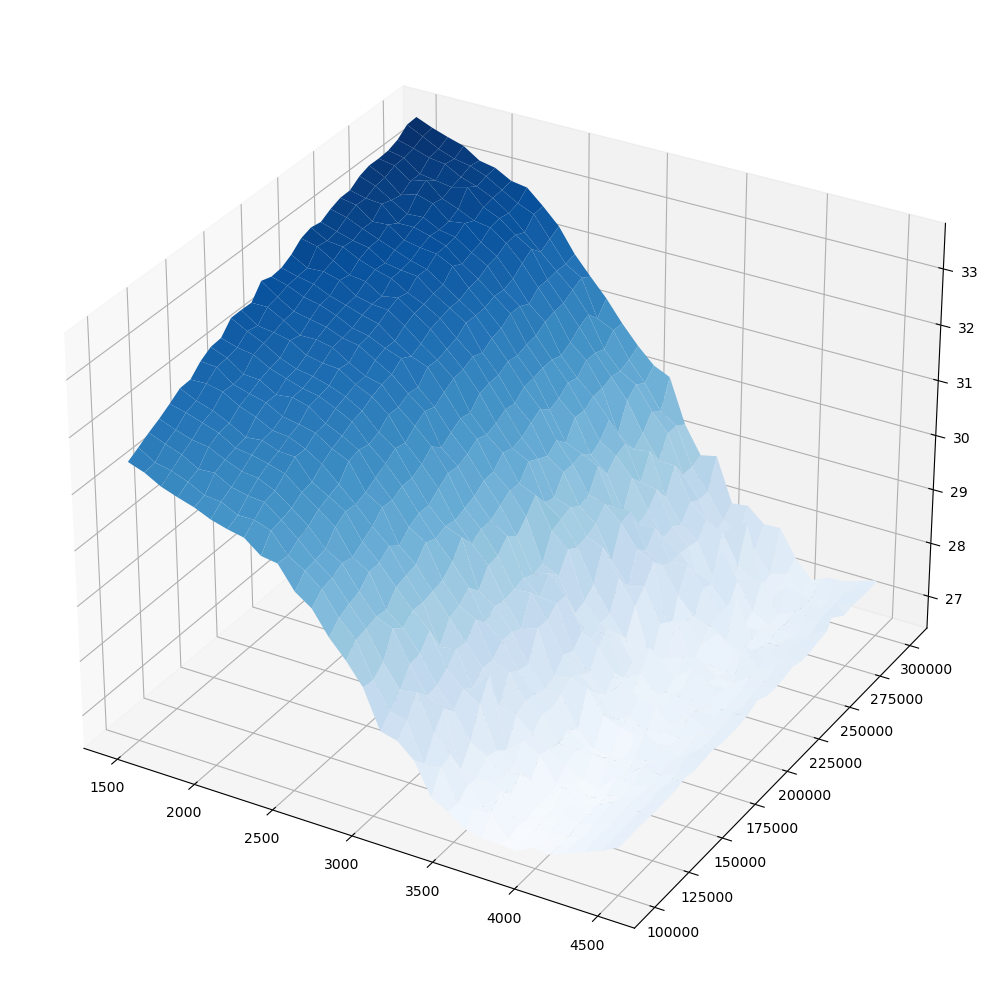

CPU times: user 6.89 s, sys: 10.7 s, total: 17.6 s
Wall time: 1h 9min 33s


In [127]:
%%time
rand_seeds = np.random.randint(0, 100000, size=len(phis))
args = []
for phi_args, rs in zip(phis, rand_seeds):
    args.append((phi_args, rs, 100, 10000, True))

mloss = 0
processes = 72
with Pool(processes) as pool:
    mloss = pool.starmap(wrapper, args)

losses = []
params = []
for loss, param in mloss:
    losses.append(loss)
    params.append(param)
    
min_arg = np.argmin(np.asarray(losses))
plt.figure(figsize=(15,5))
plt.plot(losses, label=f'min phi = {params[min_arg]} vs true = {true_phi}, argnum = {min_arg}')
plt.grid()
plt.legend()
plt.show()

losses_z = np.asarray(losses).reshape(phis_coords[0].shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
ax.plot_surface(phis_coords[0], phis_coords[1], np.log(losses_z), cmap=cm.Blues)
plt.show()

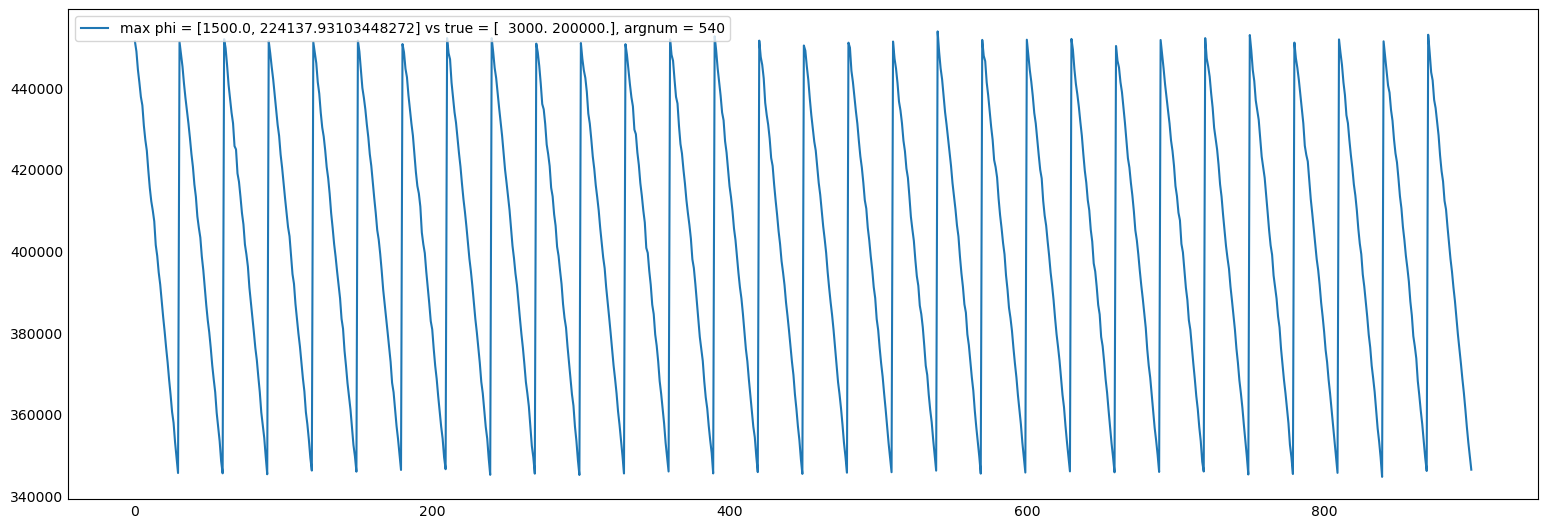

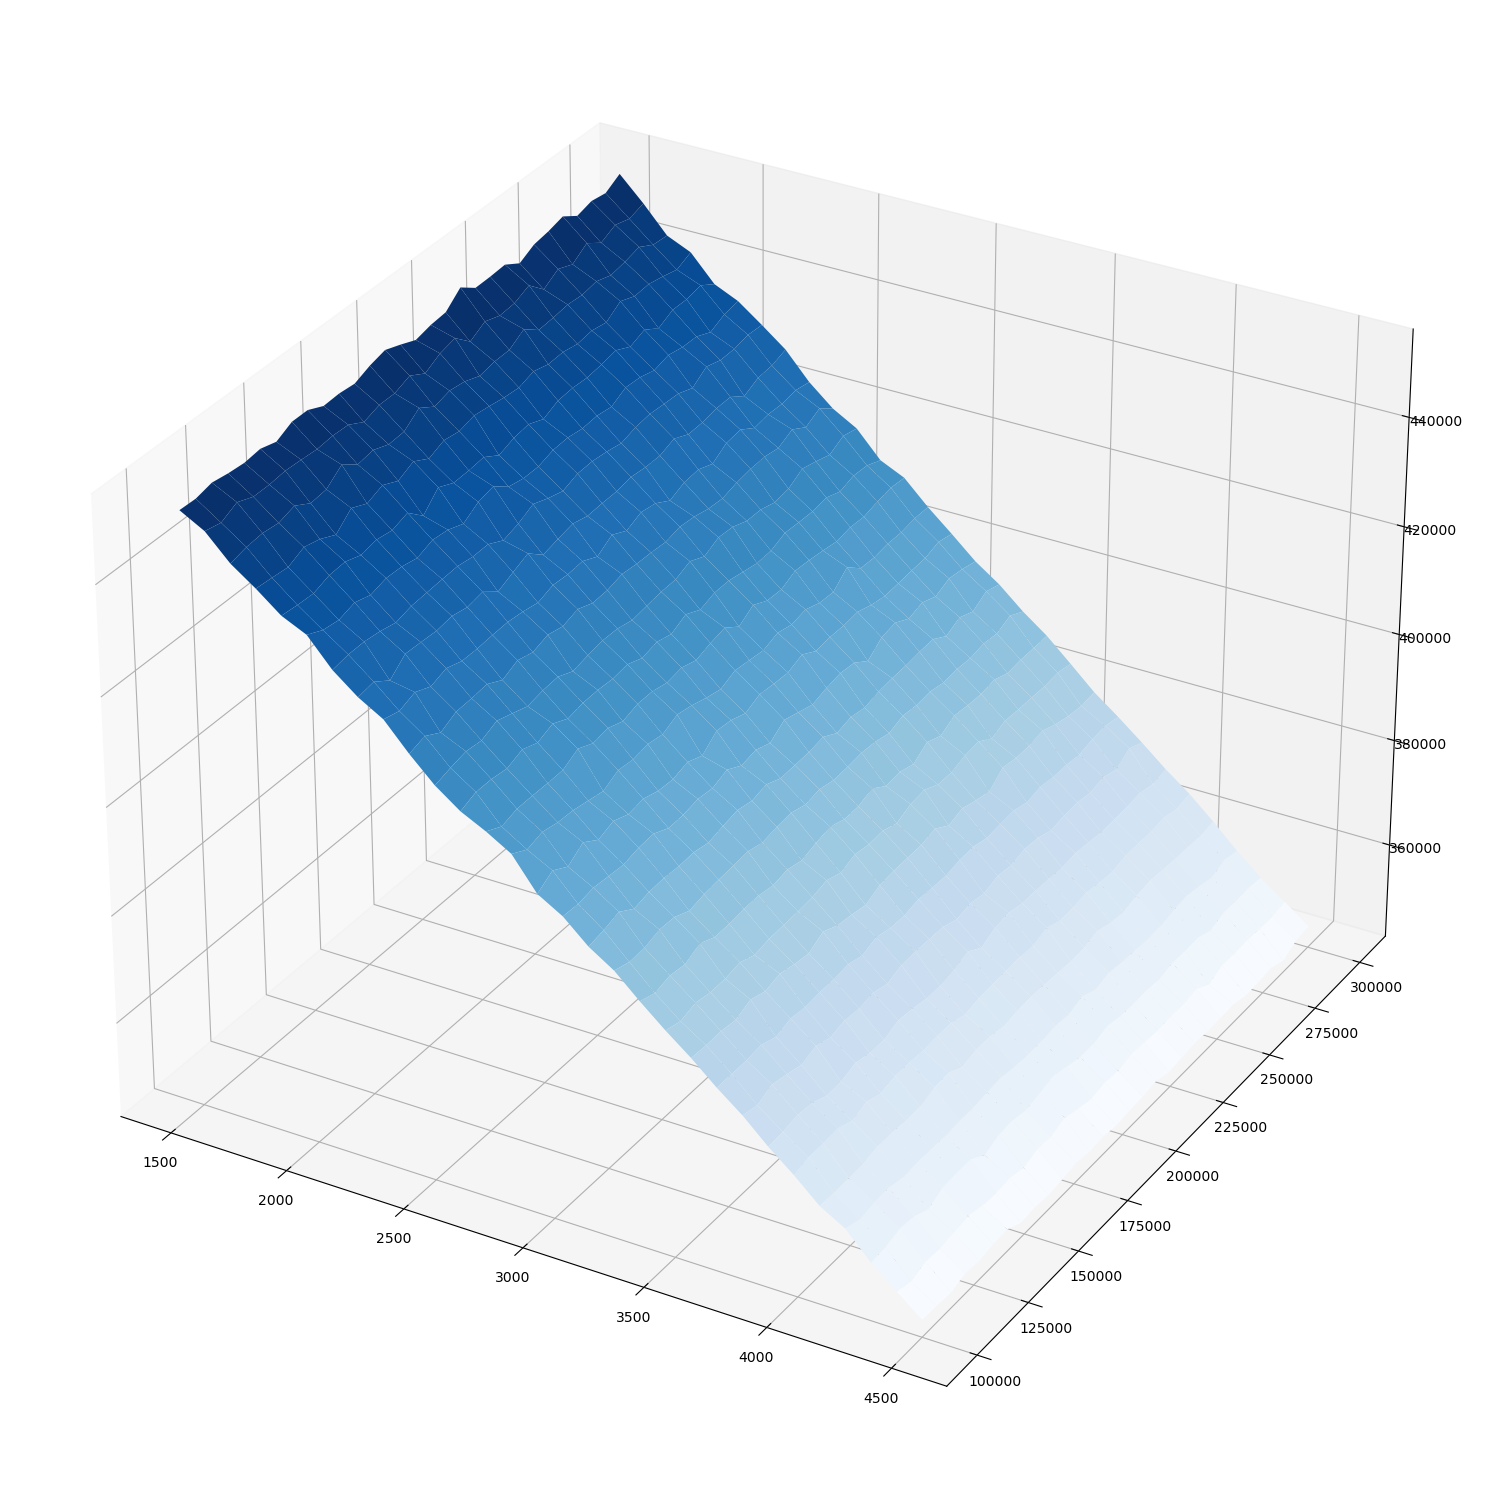

CPU times: user 2.98 s, sys: 8.59 s, total: 11.6 s
Wall time: 19.9 s


In [121]:
%%time
rand_seeds = np.random.randint(0, 100000, size=len(phis))
args = []
for phi_args, rs in zip(phis, rand_seeds):
    args.append((phi_args, rs, 100, 10, False))

with Pool(len(phis)) as pool:
    total_revenue = pool.starmap(wrapper, args)
    
revenues = []
params = [] 
for revenue, param in total_revenue:
    revenues.append(revenue)
    params.append(param)

max_arg = np.argmax(np.asarray(revenues))
plt.figure(figsize=(15,5))
plt.plot(revenues, label=f'max phi = {params[max_arg]} vs true = {true_phi}, argnum = {max_arg}')
plt.legend();plt.grid()
plt.show()

revenues = np.asarray(revenues).reshape(phis_coords[0].shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,15))
ax.plot_surface(phis_coords[0], phis_coords[1], revenues, cmap=cm.Blues)
plt.show()

Gradient for ML (theta*, phi) = 0 !!! => check whether the gradient is zero


In [314]:
np.linalg.eigvals(np.random.normal(size=(5,5)))

array([-1.14888979+1.04730095j, -1.14888979-1.04730095j,
        1.71949728+0.39214676j,  1.71949728-0.39214676j,
        0.41881871+0.j        ])

In [12]:
from typing import Callable, Dict
from scipy.special import roots_hermite
import matplotlib.pyplot as plt
%matplotlib inline
import copy, time
import multiprocessing
from numba import jit
from IPython.display import clear_output

#------------------------------------------------------------#
# Exploratory Mean Quadratic Variance algorithm
#------------------------------------------------------------#
class MultiprocessingEMQV: 
    '''
        EMQV is an offline policy algorithm 
        ---
        This is multiprocessing version that parallelize learning episodes 
        due to the fact we calculate average over several independent episodes
    '''
    def __init__(self, exec_env: ExecutionEnvironment, agent: ACAgent):
        self.exec_env   = exec_env
        self.agent      = agent
       
    def run_one_episode(
        self,
        agent: ACAgent,
        exec_env: ExecutionEnvironment,
        **kwargs
    ) -> np.ndarray:
        
        # run one trading episode 
        #print(f'\nThis ABM has seed {exec_env.process.seed}\n')

        # drop environment to its initial state
        exec_env.reset()
        exec_time = exec_env.state.remaining_time
        dt =  exec_time / N_trades
        
        # info
        revenues     = []
        price        = [exec_env.process.price]
        inventory    = [exec_env.state.initial_inventory]
        TWAP         = [exec_env.step(-exec_env.state.current_inventory, exec_time, exec_time, frozen_price=True )[1]]
        state_values = [agent.value_function(exec_time, 0, exec_env.state.current_inventory, exec_env.process.price)]
    
        # statistics
        price_trajectory     = np.zeros(N_trades + 1, dtype=float)
        inventory_trajectory = np.zeros(N_trades + 1, dtype=float)
        exploratory_reward   = np.zeros(N_trades + 1, dtype=float)
        delta_P              = np.zeros(N_trades + 1, dtype=float)
        revenue_trajectory   = np.zeros(N_trades + 1, dtype=float)
        
        sqrt_pi = np.sqrt(np.pi)
        # for Gauss-Hermite quadrature
        reward_vector        = np.zeros(explor_grid_nodes)
        abscissas_y, weights_w = roots_hermite(explor_grid_nodes, mu=False)

        #=============== execution episode ===============#

        for time_step in range(N_trades):
            
            prev_price = exec_env.process.price
            
            # calculate mean and variance of policy ~ N(mu, sigma)
            mu    = agent.get_mu(exec_env.state.current_inventory, exec_time, exec_time - exec_env.state.remaining_time)
            sigma = agent.dzeta * agent.phi[1]

            # collect exploration reward
            for j in range(explor_grid_nodes):
                trading_rate_v = mu + np.sqrt(2) * sigma * abscissas_y[j]
                _, reward_vector[j] = exec_env.step( trading_rate_v * dt, dt, dt, frozen_price=True ) # = order size inside

            # calculate exploratory reward
            exploratory_reward[time_step] = np.dot(weights_w, reward_vector) / sqrt_pi

            # execute the order
            order = mu * dt
            next_price, revenue = exec_env.step(order, dt, dt, False)
            
            # collect statistics
            revenues.append(revenue)
            TWAP.append(exec_env.step(-exec_env.state.current_inventory, exec_env.state.remaining_time, exec_env.state.remaining_time, frozen_price=True )[1]) #exec_env.state.current_inventory * exec_env.process.price)
            price.append(exec_env.process.price)
            inventory.append(exec_env.state.current_inventory)
            state_values.append(agent.value_function(exec_time, exec_time - exec_env.state.remaining_time, exec_env.state.current_inventory, exec_env.process.price))

            # calculate delta_P
            '''formula for delta_P is given by (39) | Note that exp_rew[t] == r_t * dt'''
            delta_P[time_step] = ( exploratory_reward[time_step] + prev_price * order + inventory[-2] * (next_price - prev_price) )

            # print(f'order = {order}')

            # add price and inventory movements to trajectories 
            price_trajectory[time_step + 1]      = exec_env.process.price 
            inventory_trajectory[time_step + 1]  = exec_env.state.current_inventory
            revenue_trajectory[time_step]        = revenue
        revenue_trajectory[time_step + 1]        = 0

        #========== the end of execution episode ==========#
        
        #========== policy evaluation ==========#

        # drop to zero 3d-gradient for ML, Vi on each episode 
        d_theta_ML = np.zeros(4, dtype=float)
        d_theta_Vi = np.zeros((3, N_trades + 1), dtype=float)

        # calculate theta_gradient
        '''value function partial derivatives are given by (31, 32, 33)'''
        
        tis = np.linspace(0, exec_time, N_trades + 1)
        #print(f'tis {tis.shape}, inventory {inventory_trajectory.shape}, ')
        d_theta_Vi[0] = - np.square(inventory_trajectory) / 2
        
        d_theta_Vi[1] = d_theta_Vi[0] / np.tanh(agent.phi[0] * (exec_time - tis + 1e-20))\
            - agent.dzeta * agent.phi[1] / (2 * agent.phi[0]) * (exec_time - tis)
        
        d_theta_Vi[2] = d_theta_Vi[0] * agent.phi[0] * (exec_time - tis) \
                                / ( ( np.sinh( agent.phi[0] * (exec_time - tis + 1e-10) ) ) ** 2 ) \
                                - agent.dzeta * agent.phi[1] * (exec_time - tis) / (2 * agent.phi[0]) 

        temp_part_term = np.cumsum( (exploratory_reward - agent.ra_lambda * delta_P**2)[::-1] )
        
        for k in range(3): # for each partial derivative
            '''element of sum series is given by (30)'''
            diff = d_theta_Vi[k] \
            * (-agent.value_function(exec_time, tis, inventory_trajectory, price_trajectory) \
               + agent.dzeta * (exec_time - tis) * np.log(np.sqrt(2 * np.pi * np.exp(1) * agent.dzeta * agent.phi[1])) \
               + temp_part_term)
 
            # increment Martingale Loss function by partial derivative multiplied -2*dt using formula (30)
            d_theta_ML[k] = (-2) * diff.sum() * dt
        
        '''Loss function is given above the (30)'''
        d_theta_ML[-1] = np.square(-np.asarray(state_values) + agent.dzeta * (exec_time - np.linspace(0, exec_time, N_trades+1))\
               * np.log(np.sqrt(2*np.pi*np.exp(1)*agent.dzeta*agent.phi[1])) + np.cumsum( (exploratory_reward - agent.ra_lambda * delta_P**2)[::-1] )).sum() * dt
                    
        #========== the end of learning episode ==========#
        
        return d_theta_ML
    
    def episodes_runner(
        self, 
        kwargs
    ):
        # wrapper to make copies for each process
        sub_agent = copy.deepcopy(self.agent)
        sub_env = copy.deepcopy(self.exec_env)
        sub_env.process.seed = kwargs.get('seed')
        return self.run_one_episode(sub_agent, sub_env, **kwargs)
        
        
    def simulate(self, 
                 N_trades:          int,
                 learning_epochs:   int,
                 learning_episodes: int,
                 explor_grid_nodes: int,
                 alpha_phi:         np.ndarray, 
                 alpha_t:           float,
                 ap_update_rule:    Callable[[float, int], float], # callable decay schemes
                 at_update_rule:    Callable[[float, int], float],
                 phi_field:         np.ndarray,
                 theta_field:       np.ndarray,
                 render:            bool = False,
                 verbose:           bool = False,
                 processes_num:     int = None,
                 verbose_freq:      int = 5,
        ):
        
        exec_time         = self.exec_env.state.remaining_time
        dt                = exec_time / N_trades
        trades_per_step   = 1
        step_dt           = dt / trades_per_step
        
        # for Gauss-Hermite quadrature
        abscissas_y, weights_w = roots_hermite(explor_grid_nodes, mu=False)

        reward_vector  = np.zeros(explor_grid_nodes, dtype=float)
        rewards        = np.zeros(learning_episodes, dtype=float)
        price_change   = np.zeros(learning_episodes, dtype=float)
        theta_traj     = np.zeros((learning_epochs, 3), dtype=float)
        phi_traj       = np.zeros((learning_epochs, 2), dtype=float)
        M_grad_traj    = np.zeros((learning_epochs, 3), dtype=float)
        M_loss_traj    = np.zeros(learning_epochs, dtype=float)
        
        print(f'Agent with theta = {self.agent.theta}, phi = {self.agent.phi}')
        print(f'True phi = {true_phi}, true theta = {true_theta}')
        
        #theta_scaler = 1e7
        phi_flag = True
        one_time_flag = True
        alpha_t = 0
        
        theta_grad = []
        
        if processes_num is None:
            processes_num = 8
        
        for epoch in range(learning_epochs):
            
            np.random.seed( int( ((time.time() % 1e16) * 1e6) % 1e5 ) )
            seeds = np.random.randint(0, 1000, size=learning_episodes)
            
            args = []
            for seed in seeds:
                args.append( ({'seed': seed}) )
            
            with multiprocessing.Pool(processes_num) as pool:
                theta_grad_loss = pool.map(self.episodes_runner, args)
                
            # calculate theta gradient and update theta
            # take the average over learning episodes
            np_theta_grad_loss = np.asarray(theta_grad_loss).mean(axis=0)
            #print(np_theta_grad_loss)
            theta_grad = np_theta_grad_loss[:-1] # / self.exec_env.state.initial_inventory**2
            #print(theta_grad, np_theta_grad_loss[-1])
            M_loss_traj[epoch] = np_theta_grad_loss[-1]
            #print(M_loss_traj)
                
            '''Policy Evaluation step from Step 1 of EMQV (page 14)'''
            
            '''S_Matrix is just before Lemma 5.2'''
            S_matrix = self.agent.S_matrix(exec_time, self.exec_env.state.initial_inventory)
            L_phi = 2 * self.agent.L_norm(S_matrix)
            alpha_theta = L_phi/2 + 1

            eigen_values = np.real(np.linalg.eigvals(S_matrix))
            lambda_min, lambda_max = np.min(eigen_values), np.max(eigen_values)
            
            '''Condition from (51)'''
            # consider 0 < lambda_alpha_phi <= 1 - epsilon_lambda, epsilon_lambda in (0, 1)
            if L_phi / 2 < alpha_theta < lambda_max + lambda_min:
                lamda_alpha_phi = 2 * lambda_max / alpha_theta - 1
            elif alpha_theta >= lambda_max + lambda_min:
                lamda_alpha_phi = 1 - 2 * lambda_min / alpha_theta

            self.agent.theta_t = self.agent.theta - theta_grad / alpha_theta * at_update_rule(epoch)

            if verbose and epoch % verbose_freq == 0:
                print(f'\nAlpha_theta = {alpha_theta}\n')
                print(f'\nLambda alpha phi = {lamda_alpha_phi}\n')   
                print(f'\ntheta_grad = {theta_grad},alpha = {alpha_theta}\nscaled = {theta_grad / alpha_theta * at_update_rule(epoch)}\n')
                print(f'theta = {self.agent.theta}')
                print(f'phi = {self.agent.phi}\n')
                                
            #========== the end of policy evaluation ==========#

            #========== policy gradient ==========#

            # construct inv_M(Ф)_l
            self.agent.update_M_phi_inv(self.exec_env.process.start_price)

            # construct psy = inv_M * theta = [ kappa_imp, eta_imp, sigma**2_imp ]
            '''is given by (29)'''
            self.agent.psy = np.dot(self.agent.M_phi_inv, self.agent.theta)
            
            # calculate policy gradient dphi_G
            '''partial derivatives are given by (36), (37)'''
            d_phi1_G  = - self.exec_env.state.initial_inventory ** 2 * self.agent.theta_t[2] / 2 * self.agent.g_function(exec_time)
            d_phi2_G  = self.agent.dzeta * exec_time\
                * ( 1 / (2 * self.agent.phi[1]) - (self.agent.theta_t[1] + self.agent.theta_t[2]) / (2 * self.agent.phi[0]) )
            
            # find alpha as max 
            # default phi boundaries:
            lower_phi_1, upper_phi_1 = 10, 10_000
            lower_phi_2, upper_phi_2 = 1000, 1_000_000
            
            '''condition is given by (45)'''
            upper_dGdphi_dphi1 = d_phi1_G / (upper_phi_1 - self.agent.phi[0])
            lower_dGdphi_dphi1 = d_phi1_G / (lower_phi_1 - self.agent.phi[0])
            upper_dGdphi_dphi2 = d_phi2_G / (upper_phi_2 - self.agent.phi[1])
            lower_dGdphi_dphi2 = d_phi2_G / (lower_phi_2 - self.agent.phi[1])
            
            alpha_phi = max(max(upper_dGdphi_dphi1, lower_dGdphi_dphi1), max(upper_dGdphi_dphi2, lower_dGdphi_dphi2))
            
            #print((lower_phi_1 - self.agent.phi[0]), (upper_phi_1 - self.agent.phi[0]), (lower_phi_2 - self.agent.phi[1]), (upper_phi_2 - self.agent.phi[1]))
            #print(f'lower phi = {lower_phi_1, lower_phi_2}, upper = {upper_phi_1, upper_phi_2}\nactual phi = {self.agent.phi}')
            
            '''C_RC is given by (53)'''
            epsilon = 0.01
            if self.agent.theta_t[2] <= 0:
                C_RC = lamda_alpha_phi / (self.agent.phi[0] * (1 - epsilon - lamda_alpha_phi)) * d_phi1_G
            else:
                C_RC = - (1 - epsilon) / (self.agent.phi[0] * (1 - epsilon - lamda_alpha_phi)) * d_phi1_G
      
            '''mu_g, L_g are positive constants from Lemma 5.3, 5.4'''
            mu_g, L_g = 1e4, 1e4 # arbitrary ...
            
            alpha_phi = max( max(alpha_phi, L_g), C_RC) / 1e4

            if verbose and epoch % verbose_freq == 0:
                print(f'\nC_RC = {C_RC}\n')
                print(f'\nAlpha phi = {alpha_phi}\n')
                print(f'\nd_G grad = {d_phi1_G, d_phi2_G}, alpha = {alpha_phi}')
                print(f'd_G grad scaled = {d_phi1_G/alpha_phi, d_phi2_G/alpha_phi}\n')

            # update phi using gradient ascent
            '''gradient ascent is given by (38)'''
            self.agent.phi[0] += d_phi1_G / alpha_phi
            self.agent.phi[1] += d_phi2_G / alpha_phi
            
            theta_traj[epoch] = self.agent.theta
            phi_traj[epoch]   = self.agent.phi

            #========== the end of policy gradient ==========#

            #========== recalibration ==========#

            # construct M(Ф)_l+1
            self.agent.update_M_phi(self.exec_env.process.start_price)

            # update theta
            '''recalibration step is given by Step 3 of EMQV (page 15)'''
            self.agent.theta = np.dot(
                np.dot(self.agent.M_phi, self.agent.M_phi_inv),
                self.agent.theta_t )
            
            #========== the end of recalibration ==========#
            
            clear_output(True)

            if epoch > 2 and render:
                
                fig = plt.figure(figsize=(15, 8))
                gs = fig.add_gridspec(3, 20)
                mloss = fig.add_subplot(gs[0, :])
                phi1, phi2 = fig.add_subplot(gs[1, :9]), fig.add_subplot(gs[1, 11:])
                theta1, theta2, theta3 = fig.add_subplot(gs[2, :6]), fig.add_subplot(gs[2, 7:13]), fig.add_subplot(gs[2, 14:])
                
                fig_elems = [mloss, phi1, phi2, theta1, theta2, theta3]
                
                mloss.plot(range(epoch), M_loss_traj[:epoch])
                mloss.set_title('MLoss')
                
                phi1.plot(range(epoch), phi_traj[:epoch,0], label='calibrated phi 1')
                phi1.plot(range(epoch), np.full(epoch,true_phi[0]), label='true phi_1')
                phi1.set_title('Phi 1')
                phi1.legend()
                
                phi2.plot(range(epoch), phi_traj[:epoch,1], label='calibrated phi 2')
                phi2.plot(range(epoch), np.full(epoch,true_phi[1]), label='true phi 2')
                phi1.set_title('Phi 2')
                phi2.legend()
                
                theta1.plot(range(epoch), theta_traj[:epoch,0], label='calibrated theta 1')
                theta1.plot(range(epoch), np.full(epoch,true_theta[0]), label='true theta 1')
                theta1.set_title('Theta 1')
                theta1.legend()
                
                theta2.plot(range(epoch), theta_traj[:epoch, 1], label='calibrated theta 2')
                theta2.plot(range(epoch), np.full(epoch, true_theta[1]), label='true theta 2')
                theta2.set_title('Theta 2')
                theta2.legend()
                
                theta3.plot(range(epoch), theta_traj[:epoch,2], label='calibrated theta 3')
                theta3.plot(range(epoch), np.full(epoch,true_theta[2]), label='true theta 3')
                theta3.set_title('Theta 2')
                theta3.legend()
                
                for fig_elem in fig_elems: fig_elem.grid()
                plt.show()

        print(f'\nCurrent params:\nphi = {self.agent.phi}\ntheta = {self.agent.theta}')

In [18]:
%%time

#-------------------------------------#
# Exploratory Mean Quadratic Variance
#-------------------------------------#

#-------------------------------------#
# ENVIRONMENT SET UP
#-------------------------------------#

# inventory params
start_price = 100
inventory_q0 = 500
daily_volume = 5_000
bid_ask_spread = 1/8

# time params
execution_horizon = 1 # days
execution_time    = execution_horizon / 252   # there are 250 days per trading year
N_trades          = 100 #execution_horizon * 24 * 60 # 10min periods per day
dt                = execution_time / N_trades

# environment params
env_sigma = 0.3
env_kappa = 2.5e-7
env_eta = 2.5e-6
S0 = 100
risk_aversion = 1e4* env_eta
dzeta = 5
true_phi, true_theta = return_optimal_params(env_sigma, env_kappa, env_eta, start_price, risk_aversion)
print(f'Optimal params:\nphi = {true_phi},\ntheta = {true_theta}')

# create environment
sf = InventoryExecutionState(inventory_q0, inventory_q0, execution_time)
pr = AlmgrenChrissABM(start_price, env_sigma, env_kappa, env_eta)
env = ExecutionEnvironment(sf, pr)

#=====================================#

#-------------------------------------#
# AGENT SET UP
#-------------------------------------#

# agent arbitrary params, lambda depends on env_eta

phi   = true_phi
theta = true_theta

# phi = [500, 50_000]
# theta = [0.1, 0.1, 0.1]

# create agent

agent = ACAgent(risk_aversion, dzeta, phi, theta)

#=====================================#

#-------------------------------------#
# SIMULATION SET UP
#-------------------------------------#

# simulation params
N_trades = 100
phi_field = [10, 5000]
theta_field = [-1, 1]
learning_epochs   = 200 # 500 in reference
learning_episodes = 1_000
explor_grid_nodes = 15
alpha_phi = np.array([inventory_q0, 1], dtype=float)
alpha_t   = 1
ap_update_rule = lambda l: 10 #np.exp(-0.05 * l)
at_update_rule = lambda l: 1 #np.exp(-0.01 * l)
processes_num = multiprocessing.cpu_count() - 2

kwargs = {
    'N_trades': N_trades,
    'learning_epochs': learning_epochs,
    'learning_episodes': learning_episodes,
    'processes_num': processes_num,
    'explor_grid_nodes': 15,
    'phi_field': phi_field,
    'theta_field': theta_field,
    'verbose': True,
    'verbose_freq': 20,
    'render': True,
}

Optimal params:
phi = [  3000. 200000.],
theta = [2.50000000e-07 1.50000000e-02 8.67361738e-19]
CPU times: user 267 µs, sys: 602 µs, total: 869 µs
Wall time: 826 µs


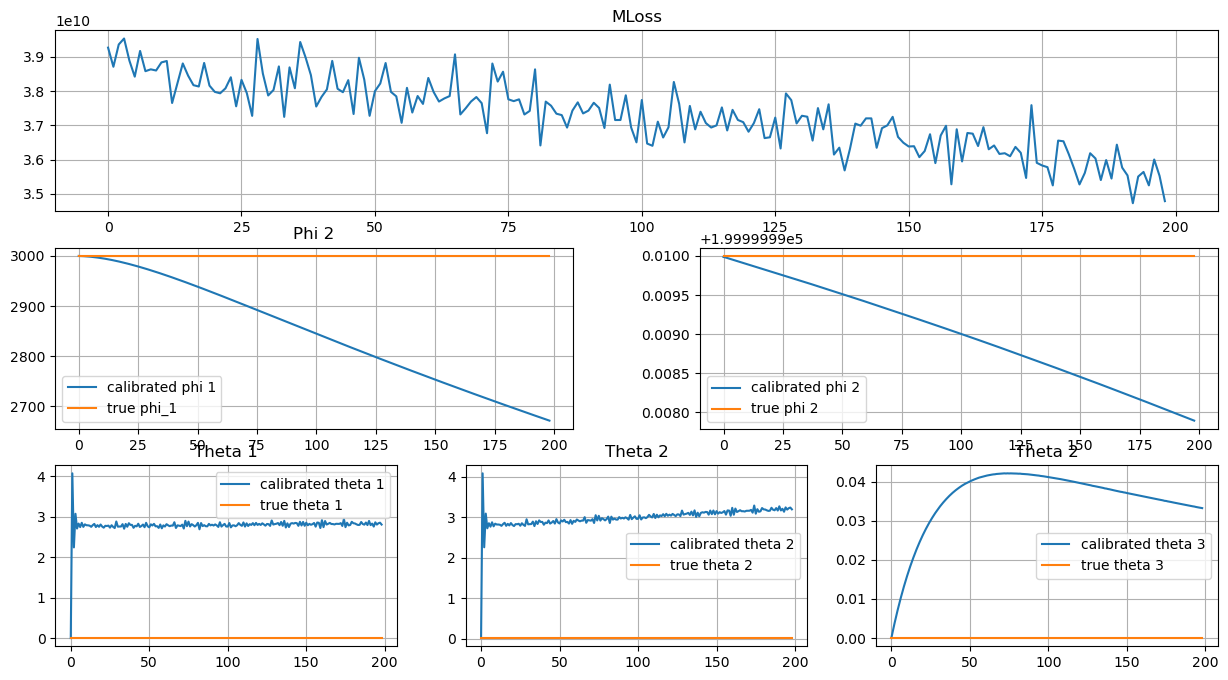


Current params:
phi = [  2669.39708557 199999.9978806 ]
theta = [2.87719891 3.2732789  0.03303479]
CPU times: user 5min 10s, sys: 12min 23s, total: 17min 34s
Wall time: 5min 20s


In [19]:
%%time 
emqv = MultiprocessingEMQV(env, agent) # add verbose param
dvs = emqv.simulate(
    alpha_phi=alpha_phi,
    alpha_t=alpha_t,
    ap_update_rule=ap_update_rule,
    at_update_rule=at_update_rule,
    **kwargs
)